## The Idea Behind Boosting

Many machine learning models rely on a **single predictive model** — examples include:

- Linear regression  
- Penalized models (e.g., Ridge, Lasso)  
- Naive Bayes  
- Support Vector Machines (SVM)

Other approaches like **bagging** and **random forests** use **ensembles** — multiple models where each predicts the target independently, and the final prediction is an **average** of these outputs.

**Boosting**, on the other hand, takes a different approach to ensembling.

### Boosting: A Sequential Ensemble Strategy

In boosting, models are added **sequentially**, and each new model is trained to correct the errors of the ensemble built so far.

Each step looks at where the current model performs poorly and builds a new model to improve those areas.

---

## Key Concepts in Boosting

### Base Learners

- Boosting builds upon **weak learners**, typically models that perform just slightly better than random.
- In most applications, **decision trees** are used as base learners.
- These are usually **shallow trees** (e.g., trees with 1–6 splits).

### Why Use Weak Learners?

- **Speed**: Shallow trees are fast to train.  
- **Controlled Learning**: Each step improves performance slowly, helping avoid overfitting.  
- **Stability**: Small, incremental improvements tend to generalize better.  

---

### How Sequential Boosting Works

Boosting works by repeatedly fitting models to the **residual errors** of the previous model.

Basic algorithm steps:

1. Start by fitting the first tree to the target values:

   $$
   F_1(x) = y
   $$

2. Fit the next tree to the residuals:

   $$
   h_1(x) = y - F_1(x)
   $$

3. Update the ensemble by adding the new tree:

   $$
   F_2(x) = F_1(x) + h_1(x)
   $$

4. Repeat the process:

   $$
   h_2(x) = y - F_2(x)
   $$

   $$
   F_3(x) = F_2(x) + h_2(x)
   $$

5. Continue this loop until a stopping criterion is met (e.g., validation performance stops improving).

The final model is the sum of all individual weak learners:

$$
f(x) = \sum_{b=1}^{B} f_b(x)
$$

---

### Illustration

Imagine we’re trying to learn a sine wave function from noisy observations:

- The **blue line** represents the true function.  
- The **points** are the observed (noisy) data.  
- Each new tree adjusts the prediction slightly, reducing the residual error.  
- Over time, the prediction **converges** to the true function.

If you have a GIF or diagram showing this sequential correction visually, this would be a good place to insert it.


![Alt text](../data/images/boosted_stumps.gif)


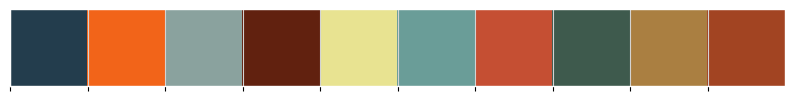

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
import optuna
import statsmodels.api as sm
import shap
shap.initjs()
import os

import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Utils.
from src.modelling_utils import * 
from src.artifacts_utils import save_object

# Fixing bayesian search error.
np.int = int

# Warnings filtering.
import warnings
warnings.filterwarnings('ignore')

# Visualization Settings
%matplotlib inline

mpl.style.use('ggplot')

mpl.rcParams['figure.figsize']      = (20, 5)
mpl.rcParams['figure.titlesize']    = 25
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['axes.linewidth']      = 1
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['font.size']           = 12
mpl.rcParams['axes.grid']           = True
# mpl.rcParams['figure.dpi']          = 150

# Palette Seting
ts_palette = ['#233D4D', '#F26419', '#8AA29E', '#61210F', '#E8E391', '#6A9D98', '#C54F33', '#3E5A4D', '#AA7F41', '#A24422']
kde_palette = ['#233D4D', '#61210F']

sns.set_palette(sns.color_palette(ts_palette))
sns.palplot(sns.color_palette(ts_palette))

In [8]:
data_path = '../data/raw/store_item_demand_forecasting/train.csv'
df_raw = pd.read_csv(data_path)
# df_raw = df_raw[(df_raw['store']==2)&(df_raw['item']==28)]

In [9]:
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw.set_index('date', inplace=True)
df_raw.sort_values(by=['date', 'store', 'item'], inplace=True)
df_raw.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,1,2,33
2013-01-01,1,3,15
2013-01-01,1,4,10
2013-01-01,1,5,11


In [10]:
print(f'The data goes from {df_raw.index.min()} to {df_raw.index.max()}.')

The data goes from 2013-01-01 00:00:00 to 2017-12-31 00:00:00.


In [11]:
CUTOFF_DATE = '2017-09-30'
train, test = time_series_split(df_raw, CUTOFF_DATE)
print(f'Train shape: {train.shape}. Train data goes from {train.index.min()} to {train.index.max()}.')
print(f'Test shape: {test.shape}. Train data goes from {test.index.min()} to {test.index.max()}.')

Train shape: (866500, 3). Train data goes from 2013-01-01 00:00:00 to 2017-09-29 00:00:00.
Test shape: (46500, 3). Train data goes from 2017-09-30 00:00:00 to 2017-12-31 00:00:00.


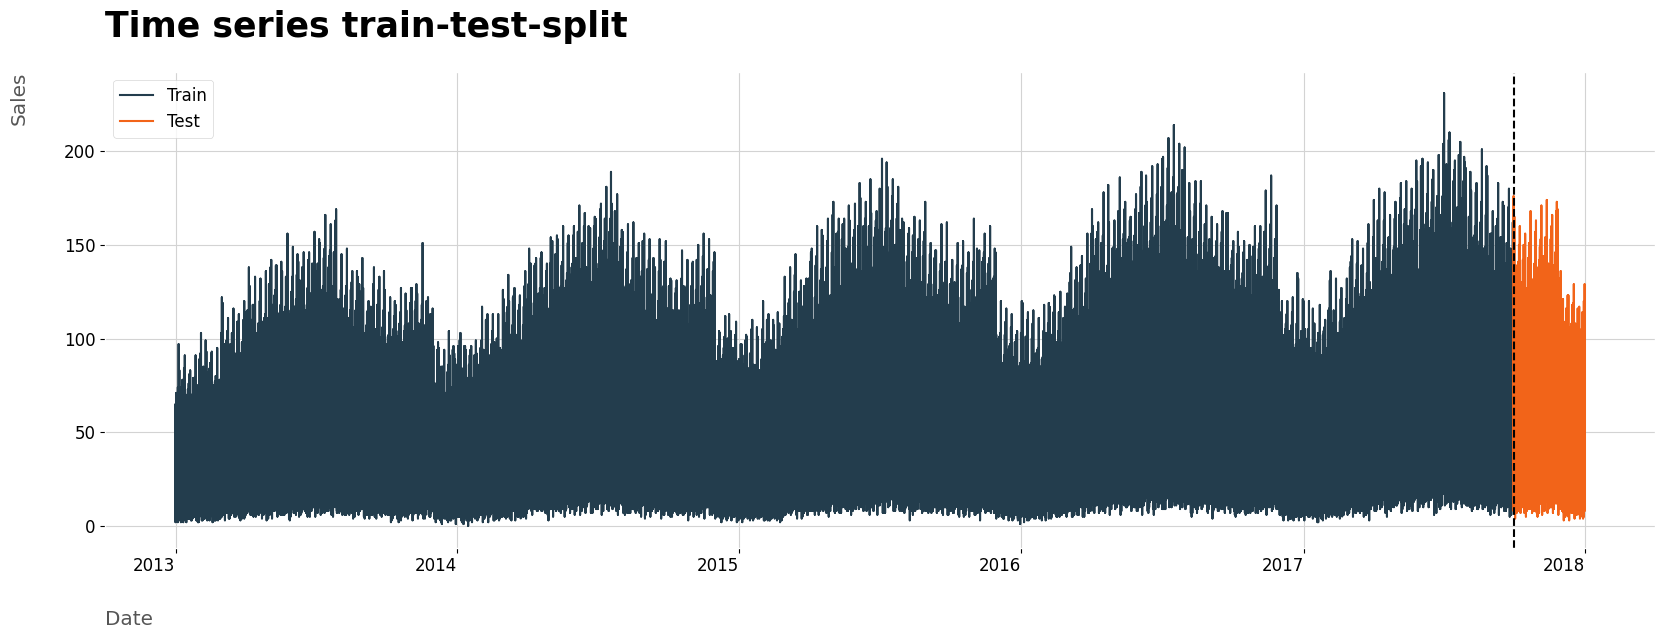

In [12]:
plot_time_series_split(train, test, CUTOFF_DATE)

<Figure size 2000x500 with 0 Axes>

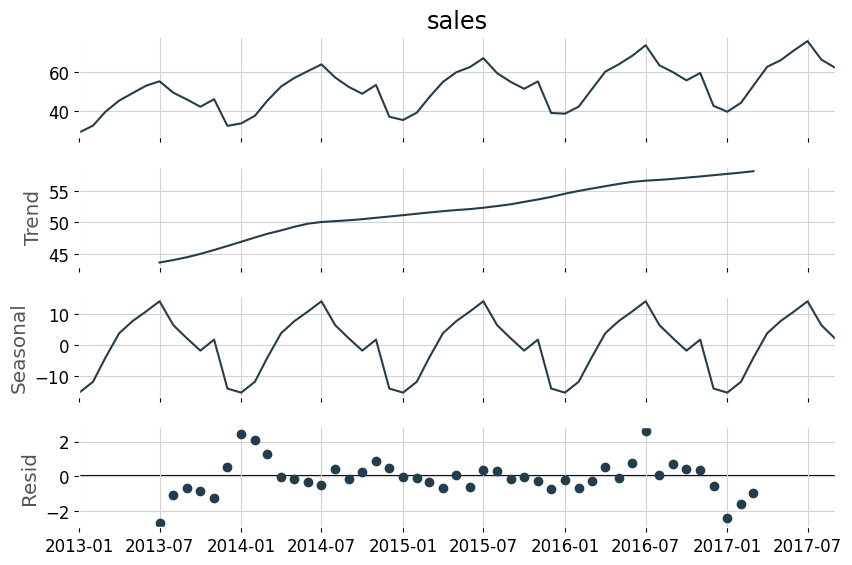

In [13]:
monthly_avg_sales = train['sales'].resample('MS').mean()
ts_decomposition = sm.tsa.seasonal_decompose(monthly_avg_sales, model='additive')

fig = plt.figure()  
fig = ts_decomposition.plot()  
fig.set_size_inches(8, 6)

------------------------------
Fold 0
Train: 0 to 723499
Validation: 727000 to 773499
------------------------------
Fold 1
Train: 0 to 769999
Validation: 773500 to 819999
------------------------------
Fold 2
Train: 0 to 816499
Validation: 820000 to 866499


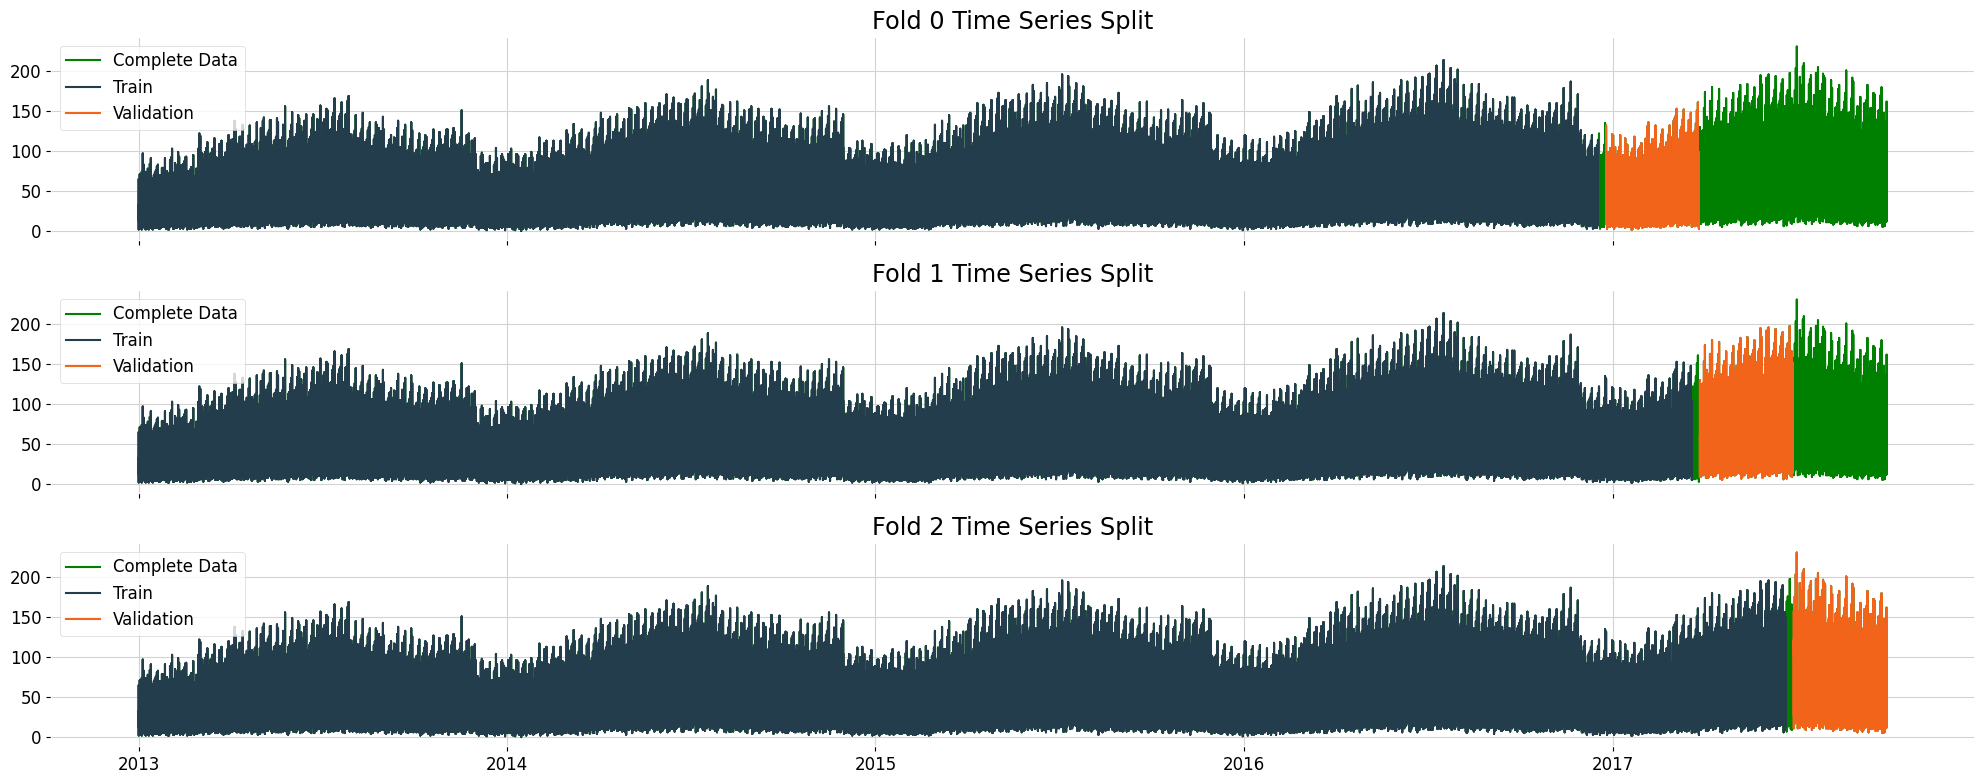

In [14]:
TEST_SIZE, GAP, TARGET = 1*93*50*10, 1*7*50*10, 'sales'
# TEST_SIZE, GAP, TARGET = 1*93, 1*7, 'sales'

time_series_cv_report(train,  target=TARGET, test_size=TEST_SIZE, gap=GAP, n_splits=3)

In [15]:
df_date = create_time_series_features(df_raw, TARGET, date_related=True)
df_date.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,13,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,33,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,15,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,10,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,11,1,1,1,2013,1,1,1.0,0,1,0


In [16]:
df_log = create_time_series_features(df_raw, TARGET, date_related=True, log_transformation=True)
df_log.head()

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,0,1,0
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,0,1,0


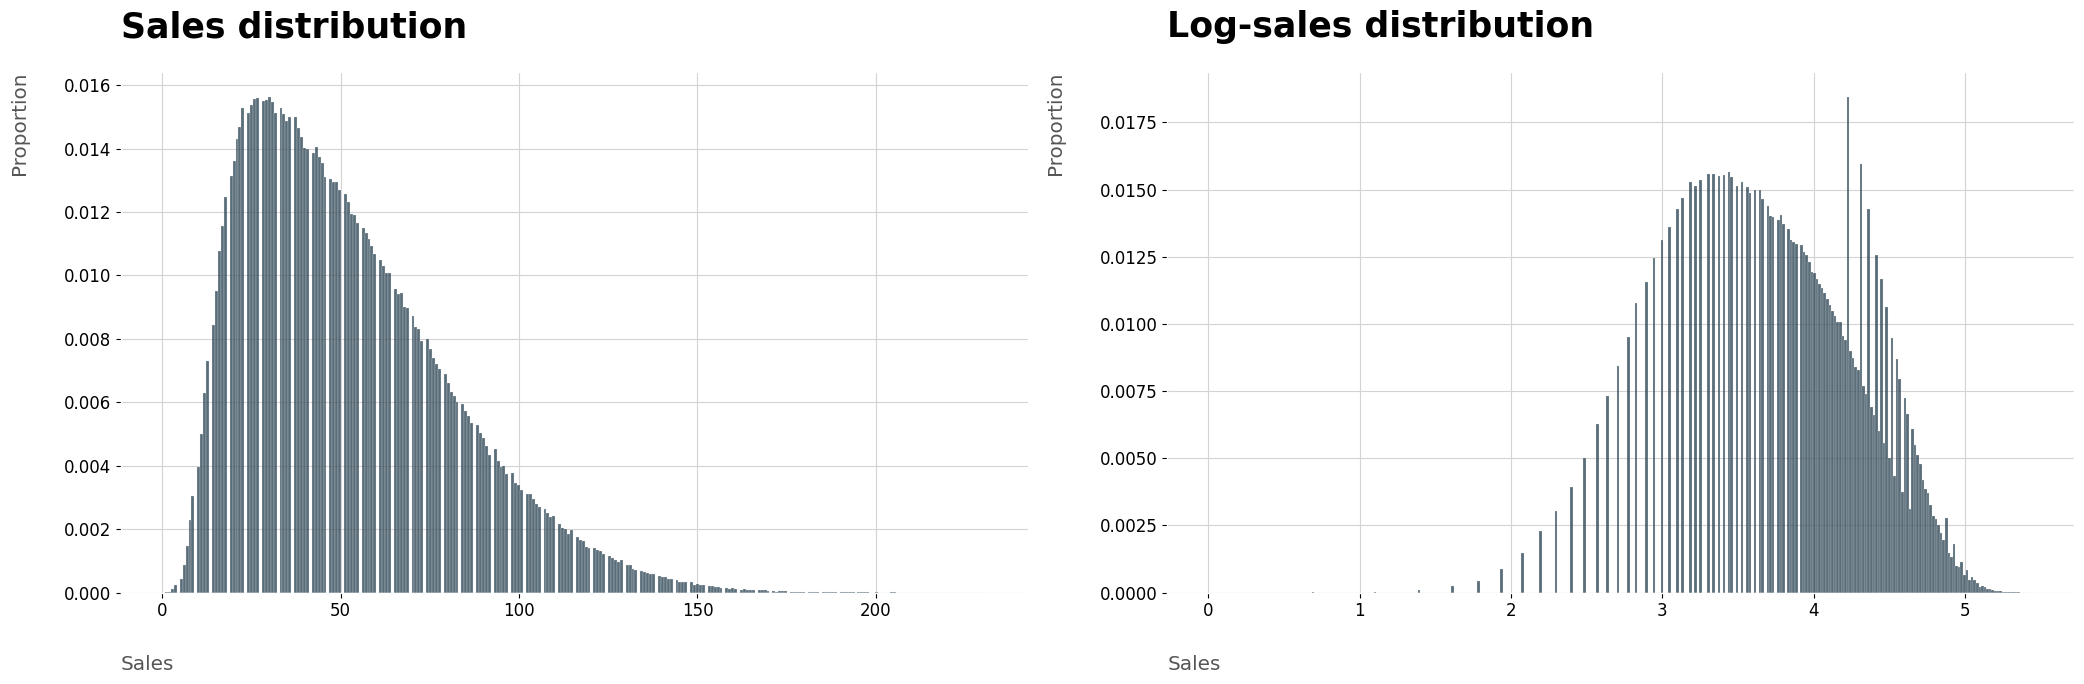

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(21, 7))

ax0 = sns.histplot(data=df_raw, x='sales', ax=ax[0], stat='proportion')
ax0.set_title('Sales distribution', fontsize=25, fontweight='bold', loc='left', pad=25)
ax0.set_xlabel('Sales', loc='left', labelpad=25)
ax0.set_ylabel('Proportion', loc='top', labelpad=25)

ax1 = sns.histplot(data=df_log, x='sales', ax=ax[1], stat='proportion')
ax1.set_title('Log-sales distribution', fontsize=25, fontweight='bold', loc='left', pad=25)
ax1.set_xlabel('Sales', loc='left', labelpad=25)
ax1.set_ylabel('Proportion', loc='top', labelpad=25)

plt.tight_layout()
plt.show()

In [18]:
TO_SORT = ['store', 'item', 'date']
TO_GROUP = ['store', 'item']
lags = [91, 98, 105, 112, 119, 126, 182, 364, 546, 728]
df_log = create_time_series_features(df_raw, TARGET, to_sort=TO_SORT, to_group=TO_GROUP, 
                                     lags=lags, date_related=True, log_transformation=True, lag=True)
# Turning back to ordered date values, necessary for time series cross validation.
df_log.sort_values(by=['date', 'store', 'item'], inplace=True)
df_log

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,6,4,12,2017,365,31,52.0,...,4.219508,4.532599,4.418841,4.634729,4.543295,4.574711,4.595120,4.276666,4.663439,3.951244
2017-12-31,10,47,3.135494,6,4,12,2017,365,31,52.0,...,3.526361,3.496508,3.433987,3.496508,3.401197,3.784190,3.688879,3.295837,3.761200,2.995732
2017-12-31,10,48,4.110874,6,4,12,2017,365,31,52.0,...,4.330733,4.454347,4.394449,4.605170,4.369448,4.564348,4.682131,3.988984,4.624973,3.970292


In [19]:
windows = [365, 546, 730]
df_roll_mean = create_time_series_features(df_raw, TARGET, TO_SORT, TO_GROUP, 
                                           lags=lags, windows=windows, min_periods=30, win_type=None, 
                                           date_related=True, lag=True, log_transformation=True, roll=True, roll_mean=True)
df_roll_mean.sort_values(by=['date', 'store', 'item'], inplace=True)

In [20]:
df_roll_std = create_time_series_features(df_raw, TARGET, TO_SORT, TO_GROUP, 
                                          lags=lags, windows=windows, min_periods=30, win_type=None, 
                                          date_related=True, lag=True, log_transformation=True, 
                                          roll=True, roll_mean=True, roll_std=True)
df_roll_std.sort_values(by=['date', 'store', 'item'], inplace=True)

In [21]:
df_roll_min_max = create_time_series_features(df_raw, TARGET, TO_SORT, TO_GROUP, 
                                          lags=lags, windows=windows, min_periods=30, win_type=None, 
                                          date_related=True, lag=True, log_transformation=True, 
                                          roll=True, roll_mean=True, roll_std=True, roll_min=True, roll_max=True)
df_roll_std.sort_values(by=['date', 'store', 'item'], inplace=True)

In [22]:
weights = [0.95, 0.9, 0.8, 0.7, 0.5]
df_ewm = create_time_series_features(df_raw, TARGET, TO_SORT, TO_GROUP, 
                                     lags=lags, windows=windows, weights=weights, min_periods=30, 
                                     win_type=None, date_related=True, lag=True, log_transformation=True, 
                                     roll=True, ewm=True, roll_mean=True, roll_std=True, roll_min=True, roll_max=True)
df_ewm.sort_values(by=['date', 'store', 'item'], inplace=True)

In [23]:
df_ewm

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_ewm_w_0.5_lag_91,sales_ewm_w_0.5_lag_98,sales_ewm_w_0.5_lag_105,sales_ewm_w_0.5_lag_112,sales_ewm_w_0.5_lag_119,sales_ewm_w_0.5_lag_126,sales_ewm_w_0.5_lag_182,sales_ewm_w_0.5_lag_364,sales_ewm_w_0.5_lag_546,sales_ewm_w_0.5_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,6,4,12,2017,365,31,52.0,...,4.332691,4.426134,4.452884,4.562643,4.452346,4.534464,4.614817,4.112102,4.598534,3.887855
2017-12-31,10,47,3.135494,6,4,12,2017,365,31,52.0,...,3.516318,3.394940,3.348013,3.520114,3.505928,3.630258,3.610838,3.290437,3.667023,3.052628
2017-12-31,10,48,4.110874,6,4,12,2017,365,31,52.0,...,4.287843,4.341329,4.336992,4.480874,4.289467,4.440345,4.556554,3.982347,4.553492,3.900692


In [24]:
train_date, _ = time_series_split(df_date, CUTOFF_DATE)
scores = time_series_cv(train_date, DummyRegressor(strategy='mean'), TARGET, TEST_SIZE, GAP, n_splits=5)

------------------------------------------------------------
DummyRegressor's time series cross validation results:
Average validation score = 32.8972
Standard deviation = 5.6701


In [25]:
scores = time_series_cv(train_date, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 9.9163
Standard deviation = 1.2625


In [26]:
train_log, _ = time_series_split(df_log, CUTOFF_DATE)
scores = time_series_cv(train_log, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.7877
Standard deviation = 0.8019


In [27]:
train_roll_mean, _ = time_series_split(df_roll_mean, CUTOFF_DATE)
scores = time_series_cv(train_roll_mean, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.3123
Standard deviation = 0.6775


In [28]:
train_roll_std, _ = time_series_split(df_roll_std, CUTOFF_DATE)
scores = time_series_cv(train_roll_std, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.323
Standard deviation = 0.6734


In [29]:
train_roll_min_max, _ = time_series_split(df_roll_min_max, CUTOFF_DATE)
scores = time_series_cv(train_roll_min_max, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.2127
Standard deviation = 0.2384


In [30]:
train_ewm, _ = time_series_split(df_ewm, CUTOFF_DATE)
scores = time_series_cv(train_ewm, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.2861
Standard deviation = 0.6678


In [31]:
# Obtain the final prepared df.
df_prep = df_ewm.copy()
df_prep

,store,item,sales,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,sales_ewm_w_0.5_lag_91,sales_ewm_w_0.5_lag_98,sales_ewm_w_0.5_lag_105,sales_ewm_w_0.5_lag_112,sales_ewm_w_0.5_lag_119,sales_ewm_w_0.5_lag_126,sales_ewm_w_0.5_lag_182,sales_ewm_w_0.5_lag_364,sales_ewm_w_0.5_lag_546,sales_ewm_w_0.5_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,2.639057,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,3.526361,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,2.772589,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,2.397895,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,2.484907,1,1,1,2013,1,1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31,10,46,4.262680,6,4,12,2017,365,31,52.0,...,4.332691,4.426134,4.452884,4.562643,4.452346,4.534464,4.614817,4.112102,4.598534,3.887855
2017-12-31,10,47,3.135494,6,4,12,2017,365,31,52.0,...,3.516318,3.394940,3.348013,3.520114,3.505928,3.630258,3.610838,3.290437,3.667023,3.052628
2017-12-31,10,48,4.110874,6,4,12,2017,365,31,52.0,...,4.287843,4.341329,4.336992,4.480874,4.289467,4.440345,4.556554,3.982347,4.553492,3.900692


In [32]:
print(f'The final data has {df_prep.shape[0]} rows and {df_prep.shape[1]} columns.')

The final data has 913000 rows and 85 columns.


In [33]:
# Obtain train and test sets, entirely and splitted in X an y.
train_prep, test_prep = time_series_split(df_prep, CUTOFF_DATE)
X_train_prep = train_prep.drop(columns=['sales'])
y_train = train_prep['sales']
X_test_prep = test_prep.drop(columns=['sales'])
y_test = test_prep['sales']
print(f'Train and target predictor and target sets shapes: {X_train_prep.shape, y_train.shape, X_test_prep.shape, y_test.shape}')

Train and target predictor and target sets shapes: ((866500, 84), (866500,), (46500, 84), (46500,))


In [ ]:
# Recursively select the features with highest feature importances until the final desired number of features is obtained.
# rfe = RecursiveFeatureEliminator(n_folds=3, 
#                                  test_size=TEST_SIZE,
#                                  gap=GAP,
#                                  scoring='neg_mean_squared_error',
#                                  estimator=LGBMRegressor(verbosity=-1),)
# rfe.fit(X_train_prep, y_train)
# X_train_selected = rfe.transform(X_train_prep)
# X_test_selected = rfe.transform(X_test_prep)
# X_train_selected.shape, X_test_selected.shape

In [36]:
X_test_selected_cols = ['store',
 'item',
 'dayofweek',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'sales_lag_91',
 'sales_lag_364',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_roll_mean_730',
 'sales_roll_std_365',
 'sales_roll_min_730',
 'sales_roll_max_365',
 'sales_roll_max_730',
 'sales_ewm_w_0.95_lag_126',
 'sales_ewm_w_0.95_lag_364',
 'sales_ewm_w_0.95_lag_546',
 'sales_ewm_w_0.9_lag_364',
 'sales_ewm_w_0.8_lag_364',
 'sales_ewm_w_0.8_lag_728',
 'sales_ewm_w_0.7_lag_364',
 'sales_ewm_w_0.5_lag_98',
 'sales_ewm_w_0.5_lag_119',
 'sales_ewm_w_0.5_lag_182',
 'sales_ewm_w_0.5_lag_364',
 'sales_ewm_w_0.5_lag_546',
 'sales_ewm_w_0.5_lag_728']

X_train_selected = X_train_prep[X_test_selected_cols]
X_test_selected = X_test_prep[X_test_selected_cols]

In [37]:
# Restablish date indexes.
X_train_selected.index = y_train.index
X_test_selected.index = y_test.index

# Visualize the final selected features.
X_train_selected.head()

,store,item,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_lag_91,...,sales_ewm_w_0.9_lag_364,sales_ewm_w_0.8_lag_364,sales_ewm_w_0.8_lag_728,sales_ewm_w_0.7_lag_364,sales_ewm_w_0.5_lag_98,sales_ewm_w_0.5_lag_119,sales_ewm_w_0.5_lag_182,sales_ewm_w_0.5_lag_364,sales_ewm_w_0.5_lag_546,sales_ewm_w_0.5_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
X_train_selected

,store,item,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,sales_lag_91,...,sales_ewm_w_0.9_lag_364,sales_ewm_w_0.8_lag_364,sales_ewm_w_0.8_lag_728,sales_ewm_w_0.7_lag_364,sales_ewm_w_0.5_lag_98,sales_ewm_w_0.5_lag_119,sales_ewm_w_0.5_lag_182,sales_ewm_w_0.5_lag_364,sales_ewm_w_0.5_lag_546,sales_ewm_w_0.5_lag_728
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,2,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,3,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,4,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,5,1,1,1,2013,1,1,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-29,10,46,4,3,9,2017,272,29,39.0,4.499810,...,4.378805,4.348530,4.100654,4.317398,4.618112,4.450930,4.110088,4.263007,4.295427,4.124992
2017-09-29,10,47,4,3,9,2017,272,29,39.0,3.496508,...,3.337388,3.344771,3.411283,3.352207,3.498538,3.597727,3.115686,3.359714,3.270789,3.351816
2017-09-29,10,48,4,3,9,2017,272,29,39.0,4.330733,...,4.312166,4.304687,4.222923,4.295466,4.365792,4.293664,4.130756,4.273061,4.178433,4.155299


In [39]:
TEST_SIZE_TUNING = 1*31*50*10
GAP_TUNING = 1*7*50*10
# TEST_SIZE_TUNING = 1*31
# GAP_TUNING = 1*7
train_selected = pd.concat([X_train_selected, y_train], axis=1)
train_sample = train_selected.iloc[766500:866500]
# train_sample = train_selected.copy()

In [40]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': 1000,
        'verbosity': -1,
        'bagging_freq': 1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2**10),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
    }

    model = LGBMRegressor(**params)
    rmse_scores = time_series_cv(train_sample, model=model, target=TARGET, test_size=TEST_SIZE_TUNING, 
                                 gap=GAP_TUNING, log=True, display_score=False)
    avg_rmse = np.mean(rmse_scores)
    
    return avg_rmse 

In [ ]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# print(f'Best params found for lightgbm: {study.best_params}')
# print(f'Best RMSE = {study.best_value}')

In [41]:
best_params = { 'objective': 'regression',
                'metric': 'rmse',
                'n_estimators': 1000,
                'verbosity': -1,
                'bagging_freq': 1,
                'learning_rate': 0.004405248775613469, 
                'num_leaves': 115, 
                'subsample': 0.5308684382722297, 
                'colsample_bytree': 0.8948096134372598, 
                'min_data_in_leaf': 71}
# best_params = {
#     'objective': 'regression',
#                 'metric': 'rmse',
#                 'n_estimators': 1000,
#                 'verbosity': -1,
#                 'bagging_freq': 1,
#     'learning_rate': 0.0192021180526396, 'num_leaves': 4, 'subsample': 0.9973668960340913, 'colsample_bytree': 0.6465908801078214, 'min_data_in_leaf': 7}


lgb_reg = LGBMRegressor(**best_params)
lgb_reg.fit(X_train_selected, y_train)
y_pred = lgb_reg.predict(X_test_selected)

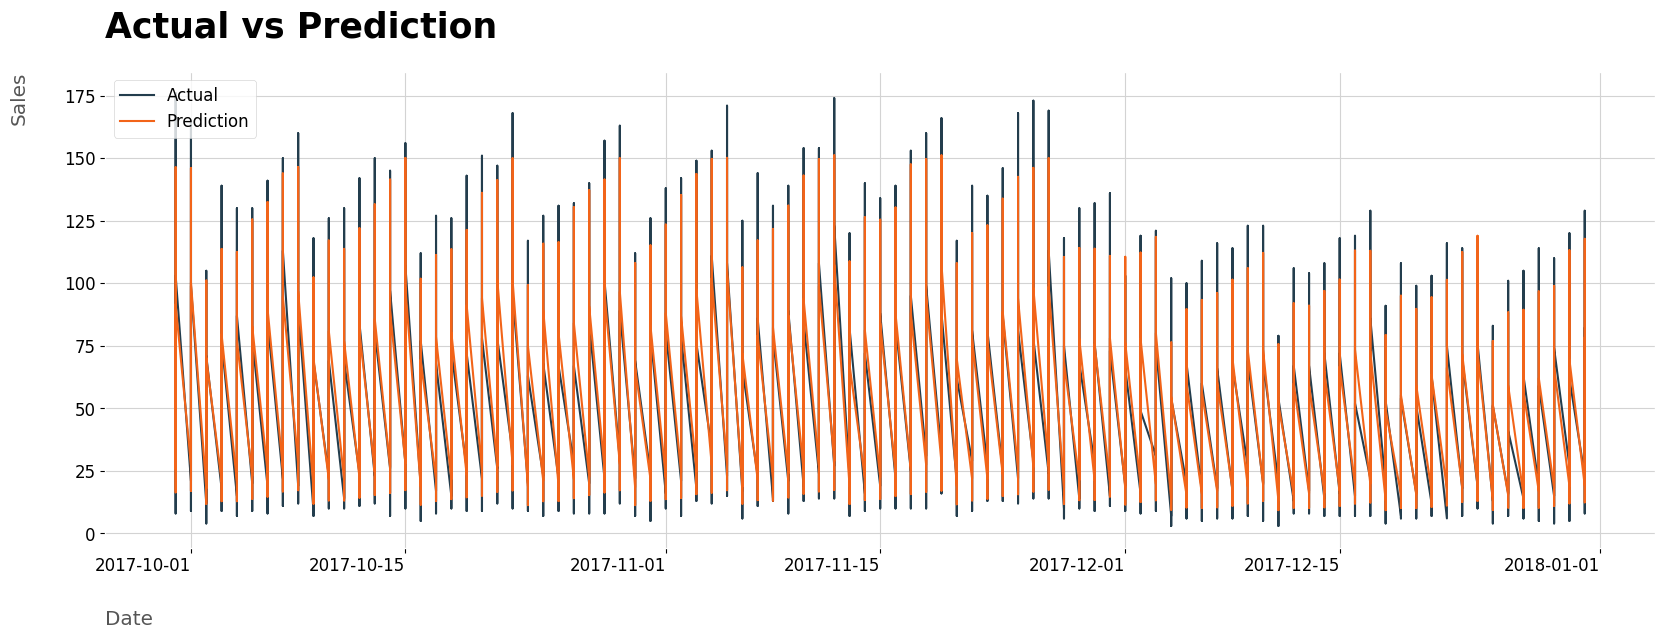

In [42]:
plot_predictions(X_test_selected.index, np.expm1(y_test), np.expm1(y_pred))

In [43]:
actual_pred_df = compare_actual_predicted(np.expm1(y_test), np.expm1(y_pred))
actual_pred_df.sample(n=15, random_state=42)

,Actual,Predicted,Residual
date,,,
2017-10-15,77.0,69.56,7.44
2017-10-04,94.0,83.77,10.23
2017-10-02,87.0,90.08,3.08
2017-10-17,22.0,29.84,7.84
2017-11-25,90.0,82.40,7.60
2017-10-14,100.0,92.02,7.98
2017-12-13,17.0,19.40,2.40
2017-11-11,50.0,62.33,12.33
2017-11-28,56.0,47.30,8.70


Mean Absolute Error (MAE): 6.0979
Mean Absolute Percentage Error (MAPE): 13.2891
Mean Squared Error (MSE): 63.5859
Root Mean Squared Error (RMSE): 7.9741
R-Squared (R2): 0.9221


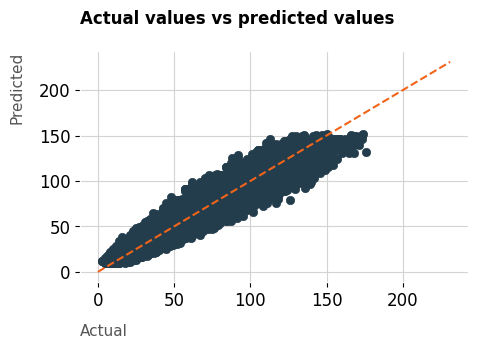

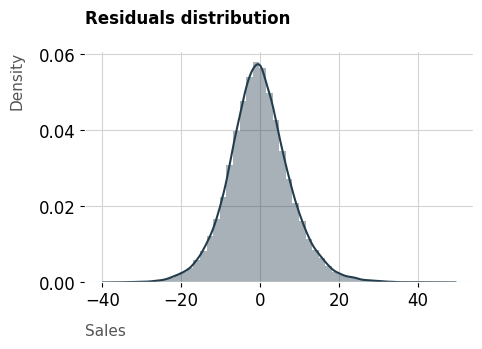

In [44]:
df_results = evaluate_regressor(np.expm1(y_test), np.expm1(y_pred), np.expm1(y_train), 'LightGBM')

In [45]:
df_results

,Model,MAE,MAPE,RMSE,R2
Results,LightGBM,6.0979,13.2891,7.9741,0.9221


In [46]:
y_pred_train = lgb_reg.predict(X_train_selected)
print(f'Training RMSE = {round(np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))), 4)}')
val_rmse = time_series_cv(train_selected, LGBMRegressor(verbose=-1), TARGET, TEST_SIZE, GAP, n_splits=5, log=True)

Training RMSE = 7.6824
------------------------------------------------------------
LGBMRegressor's time series cross validation results:
Average validation score = 8.2913
Standard deviation = 0.6598
